In [1]:
import random

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize
import matplotlib.pyplot as plt

from data_generation.image_classification import generate_dataset
from stepbystep.v1 import StepByStep
from helpers import index_splitter, make_balanced_sampler, plot_images, TransformedTensorDataset

In [2]:
lenet = nn.Sequential()

# 特征化器
# 模块1:1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))

# 模块2:6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))

# 模块3:16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func3', nn.ReLU())

# 展平
lenet.add_module('flatten', nn.Flatten())

# 分类
# 隐藏层
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func4', nn.ReLU())

# 输出层
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

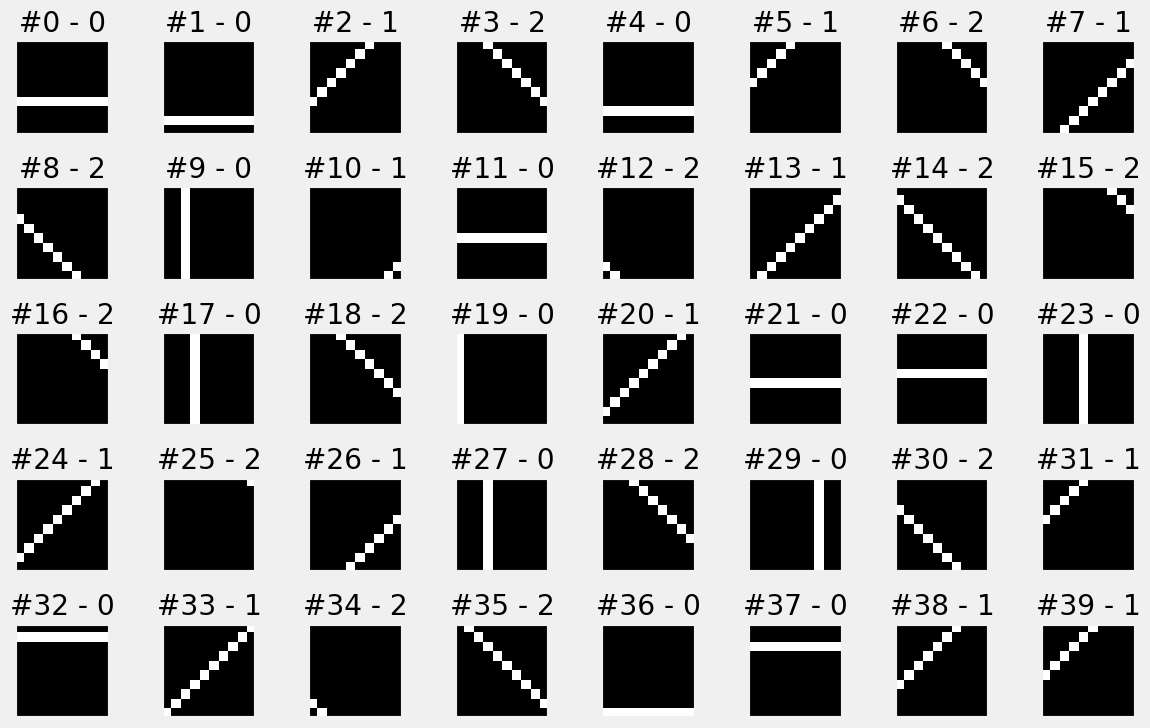

In [3]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)
fig = plot_images(images, labels, 40, 8)

In [4]:
x_tensor = torch.as_tensor(images / 255.).float()
y_tensor = torch.as_tensor(labels).long()

train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, val_composer)

sampler = make_balanced_sampler(y_train_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [5]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# 特征化器
# 模块1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# 展平: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels * 4 * 4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())

model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

In [6]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

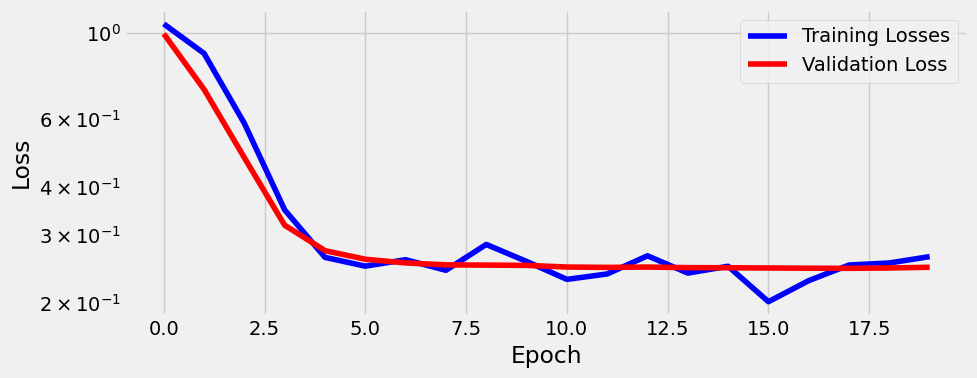

In [7]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_dataloader, val_dataloader)
sbs_cnn1.train(20)
fig = sbs_cnn1.plot_losses()

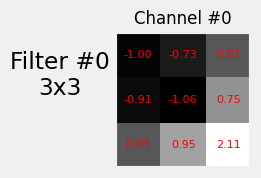

In [8]:
fig = sbs_cnn1.visualize_filter('conv1', cmap='gray')

In [9]:
sbs_cnn1.attach_hooks(
    layers_to_hook=['conv1', 'relu1', 'maxp1',
                    'flatten', 'fc1', 'relu2', 'fc2'],
)   

In [10]:
images_batch, labels_batch = next(iter(val_dataloader))
logits = sbs_cnn1.predict(images_batch)

sbs_cnn1.remove_hooks()
predicted = np.argmax(logits, 1)
predicted

array([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])

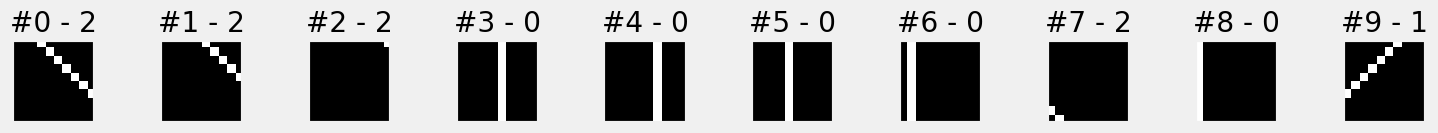

In [11]:
fig = plot_images(images_batch.squeeze(),
                  labels_batch.squeeze(), n_col=10, n_plots=10)

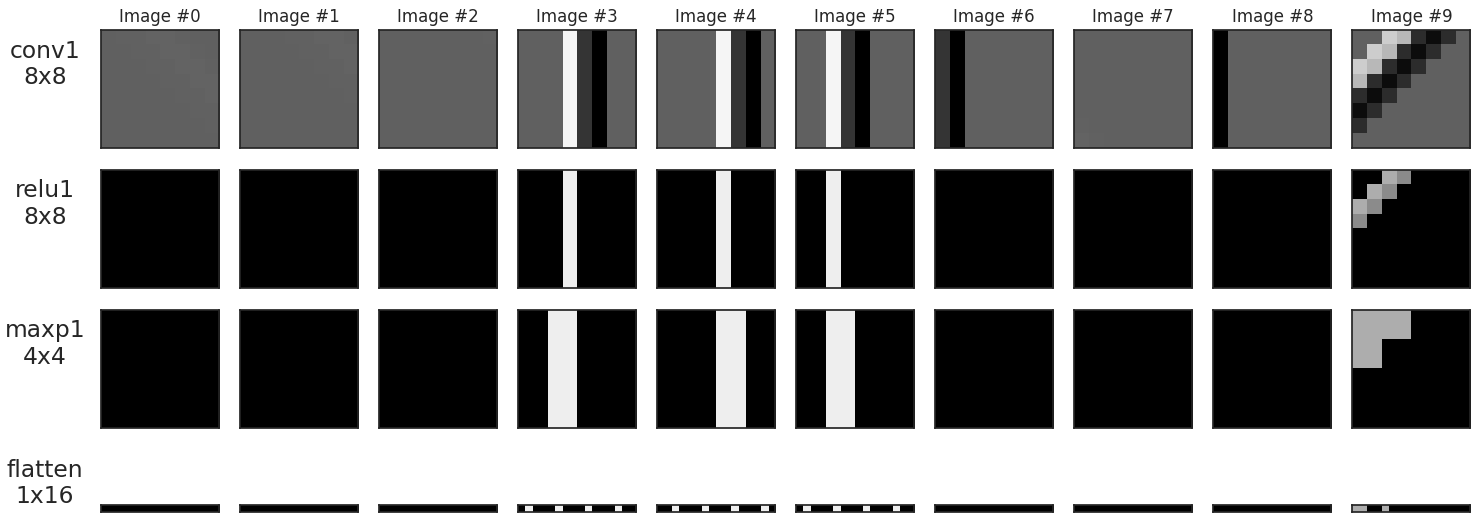

In [12]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']

with plt.style.context('seaborn-v0_8-white'):
    fig = sbs_cnn1.visualize_outputs(featurizer_layers)

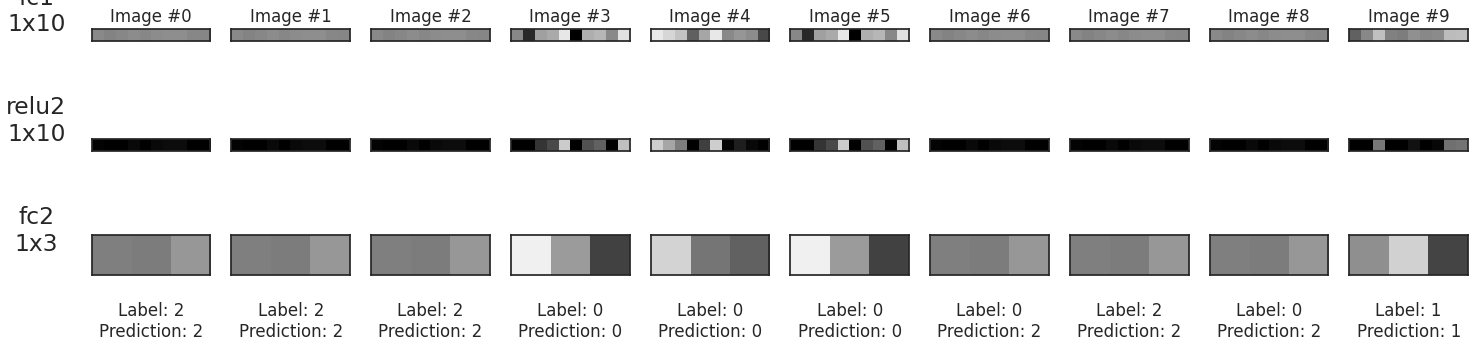

In [13]:
classifier_layers = ['fc1', 'relu2', 'fc2']

with plt.style.context('seaborn-v0_8-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, y_hat=predicted)

In [14]:
sbs_cnn1.correct(images_batch, labels_batch)

tensor([[5, 7],
        [3, 3],
        [6, 6]])

In [15]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])